In [1]:
# Step 1: Mount Google Drive and Load Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip your dataset
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model


In [4]:
# Set paths
train_data_path = '/content/dataset/Dataset/training'
validation_data_path = '/content/dataset/Dataset/validation'
test_data_path = '/content/dataset/Dataset/testing'


In [6]:
# Load and preprocess images
def load_data(data_path):
    images = []
    labels = []

    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        for filename in os.listdir(label_path):
            img = load_img(os.path.join(label_path, filename), target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load training and validation data
train_images, train_labels = load_data(train_data_path)
val_images, val_labels = load_data(validation_data_path)


In [7]:
# Use MobileNetV2 as feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
train_features = base_model.predict(train_images)
val_features = base_model.predict(val_images)


505/505 [==============================] - 96s 189ms/step


In [8]:
# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)


In [9]:
# Combine train and validation features for label propagation
all_features = np.vstack((train_features, val_features))
all_labels = np.concatenate((train_labels_encoded, -1 * np.ones(val_features.shape[0])))  # -1 for unlabeled

# Create similarity matrix
similarity_matrix = cosine_similarity(all_features)

# Label propagation
label_prop_model = LabelPropagation(kernel='knn', n_neighbors=5, max_iter=1000)
label_prop_model.fit(similarity_matrix, all_labels)


LabelPropagation(kernel='knn', n_neighbors=5)

In [10]:
# Predict on validation set
val_preds = label_prop_model.predict(similarity_matrix[:len(train_features) + len(val_features)])

# Calculate validation accuracy
val_accuracy = accuracy_score(train_labels_encoded, val_preds[:len(train_labels)])
print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.8962


In [11]:
# Load test data
def load_test_data(test_data_path):
    test_images = []
    for filename in os.listdir(test_data_path):
        img = load_img(os.path.join(test_data_path, filename), target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        test_images.append(img_array)

    return np.array(test_images)

# Load and extract features from test data
test_images = load_test_data(test_data_path)
test_features = base_model.predict(test_images)


138/138 [==============================] - 25s 177ms/step


In [13]:
# Create similarity matrix for test features
combined_features = np.vstack((all_features, test_features))
test_similarity_matrix = cosine_similarity(combined_features)

# Predict labels for test data
test_preds = label_prop_model.transduction_[-len(test_features):]


In [15]:
# Convert predicted labels back to original class names after ensuring they are integers
test_preds = test_preds.astype(int)  # Convert to integer type if needed
predicted_classes = label_encoder.inverse_transform(test_preds)

# Display predicted classes for test images
for filename, predicted_class in zip(os.listdir(test_data_path), predicted_classes):
    print(f"File: {filename} - Predicted Class: {predicted_class}")


File: fNJ6vqaS79.jpg - Predicted Class: Normal
File: fjqogXfeX7.jpg - Predicted Class: Normal
File: 7mBFJKTVyR.jpg - Predicted Class: Normal
File: SMlF2XAJ7e.jpg - Predicted Class: Normal
File: x7XH2eNe4e.jpg - Predicted Class: Normal
File: Xh40Tsxg8f.jpg - Predicted Class: Normal
File: gch4zyyg9M.jpg - Predicted Class: Normal
File: 876uzJsvz2.jpg - Predicted Class: Normal
File: q8uzGCS4jO.jpg - Predicted Class: Normal
File: 2FsrX68aH6.jpg - Predicted Class: Normal
File: CXS9Ga1CvJ.jpg - Predicted Class: Normal
File: 3waonTXsNC.jpg - Predicted Class: Normal
File: jqOiv2fqDB.jpg - Predicted Class: Normal
File: pWqQPNv33k.jpg - Predicted Class: Normal
File: gQwrIZgQcu.jpg - Predicted Class: Normal
File: cJGe0Gq58h.jpg - Predicted Class: Normal
File: sZoiEwRD2X.jpg - Predicted Class: Normal
File: Hh282zvTBm.jpg - Predicted Class: Normal
File: dbh806n1Wr.jpg - Predicted Class: Normal
File: ITjKrS8jeE.jpg - Predicted Class: Normal
File: ZgBqEXljkj.jpg - Predicted Class: Normal
File: tmxYB5q

Validation Accuracy: 0.8237
Classification Report:
                   precision    recall  f1-score   support

    Angioectasia       0.56      0.49      0.52       497
        Bleeding       0.56      0.57      0.56       359
         Erosion       0.38      0.40      0.39      1155
        Erythema       0.34      0.20      0.25       297
    Foreign Body       0.75      0.62      0.68       340
Lymphangiectasia       0.61      0.39      0.47       343
          Normal       0.91      0.95      0.92     12287
           Polyp       0.35      0.23      0.28       500
           Ulcer       0.88      0.78      0.83       286
           Worms       0.51      0.32      0.40        68

        accuracy                           0.82     16132
       macro avg       0.59      0.49      0.53     16132
    weighted avg       0.81      0.82      0.82     16132



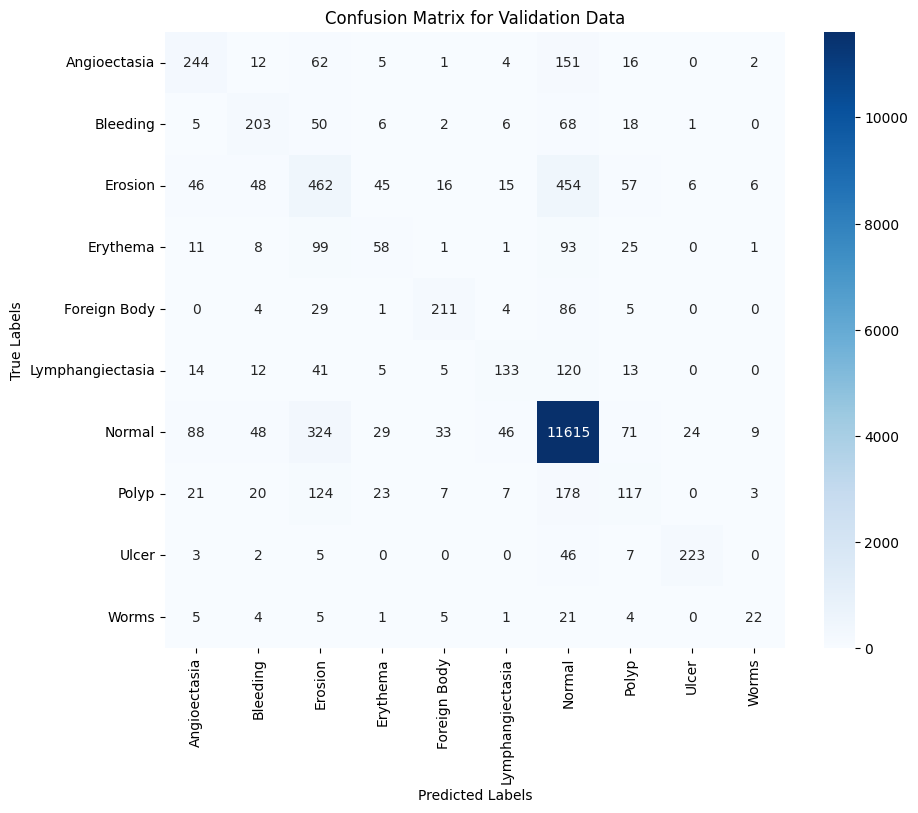

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Encode validation labels for calculating metrics
val_labels_encoded = label_encoder.transform(val_labels)

# Calculate confusion matrix and accuracy
conf_matrix = confusion_matrix(val_labels_encoded, val_preds[len(train_labels):])
val_accuracy = accuracy_score(val_labels_encoded, val_preds[len(train_labels):])

# Print validation accuracy
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report for more detailed metrics
print("Classification Report:\n", classification_report(val_labels_encoded, val_preds[len(train_labels):], target_names=label_encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Validation Data")
plt.show()
